In [2]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraped data

In [3]:
# load Data
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries)
df = load_IUCN_data()

data/IUCN/scraped/Italy.csv
data/IUCN/scraped/Korea.csv
data/IUCN/scraped/Japan.csv
data/IUCN/scraped/Poland.csv
data/IUCN/scraped/Ireland.csv
data/IUCN/scraped/Spain.csv
data/IUCN/scraped/Netherlands.csv
data/IUCN/scraped/New Zealand.csv
data/IUCN/scraped/Sweden.csv
data/IUCN/scraped/Greece.csv
data/IUCN/scraped/Slovak Republic.csv
data/IUCN/scraped/Canada.csv
data/IUCN/scraped/United States.csv
data/IUCN/scraped/Austria.csv
data/IUCN/scraped/Mexico.csv
data/IUCN/scraped/France.csv
data/IUCN/scraped/Finland.csv
data/IUCN/scraped/Norway.csv
data/IUCN/scraped/Switzerland.csv
data/IUCN/scraped/Germany.csv
data/IUCN/scraped/Portugal.csv
data/IUCN/scraped/Luxembourg.csv
data/IUCN/scraped/Belgium.csv
data/IUCN/scraped/Czech Republic.csv
data/IUCN/scraped/United Kingdom.csv
data/IUCN/scraped/Iceland.csv
data/IUCN/scraped/Australia.csv
data/IUCN/scraped/Denmark.csv
data/IUCN/scraped/Hungary.csv


In [4]:
df.head()

,kingdom_class,common_name,scientific_name,trend,region,threat_level
0,animalia — insecta,NaN,Erebia mnestra,Stable,"Global, Europe",Least Concern
1,animalia — insecta,Marbled Ringlet,Erebia montana,Stable,"Global, Europe",Least Concern
2,animalia — insecta,NaN,Erebia tyndarus,Stable,"Global, Europe",Least Concern
3,animalia — insecta,NaN,Melitaea asteria,Decreasing,"Global, Europe",Least Concern
4,animalia — insecta,NaN,Erebia pronoe,Decreasing,"Global, Europe",Least Concern


In [5]:
# extract animal class names
df['kingdom_class'] = df.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
df = df.rename(columns={'kingdom_class': 'class'})

In [6]:
df['class'].unique()

array(['insecta', 'myxini', 'gastropoda', 'actinopterygii', 'mammalia',
       'reptilia', 'chondrichthyes', 'amphibia', 'aves', 'anthozoa',
       'malacostraca', 'bivalvia', 'arachnida', 'cephalopoda',
       'holothuroidea', 'cephalaspidomorphi', 'maxillopoda', 'clitellata',
       'branchiopoda', 'echinoidea', 'hydrozoa', 'asteroidea',
       'merostomata', 'monoplacophora', 'diplopoda', 'entognatha'],
      dtype=object)

## Translate classes of animals
From Wikipedia as nothing found on IUCN

mammalia: Mammals

actinopterygii: Ray-finned fishes

insecta: Insects

amphibia: Amphibians

aves: Birds

bivalvia: clams, oysters, cockles, mussels, scallops

gastropoda: Snails and Slugs

cephalaspidomorphi: jawless fishes

clitellata: Worms

reptilia: Reptiles

chondrichthyes: cartilaginous fishes

malacostraca: crustaceans

hydrozoa: individually very small, predatory animals, most living in salt water

turbellaria: flatworms

,class,common_name,scientific_name,trend,region,threat_level,country
0,mammalia,Brown Bear,Ursus arctos,Stable,Global,Least Concern,United Kingdom
1,mammalia,Greater Mouse-eared Bat,Myotis myotis,Stable,Global,Least Concern,United Kingdom
2,actinopterygii,Atlantic sturgeon,Acipenser sturio,Decreasing,"Global, Europe",Critically Endangered,United Kingdom
3,mammalia,Wild Boar,Sus scrofa,Unknown,Global,Least Concern,United Kingdom
4,mammalia,Gray Whale,Eschrichtius robustus,Stable,Global,Least Concern,United Kingdom


In [7]:
# rename needed classes 
df['class'].replace({
    'mammalia': 'Mammals',
    'insecta': 'Insects',
    'amphibia': 'Amphibians',
    'aves': 'Birds',
    'gastropoda': 'Snails_Slugs',
    'clitellata': 'Worms',
    'reptilia': 'Reptiles',
    },
    inplace=True)

In [8]:
df.shape

(35671, 6)

In [9]:
# remove all sea animals
select_classes = ['Mammals', 'Insects', 'Amphibians', 'Birds', 'Snails_Slugs', 'Worms', 'Reptiles']
df = df[df['class'].isin(select_classes)]
df.shape

(21557, 6)

## Trends

In [10]:
# fill nan vlaues in trend with existing Unknown
df.trend.fillna('Unknown', inplace=True)

<AxesSubplot:>

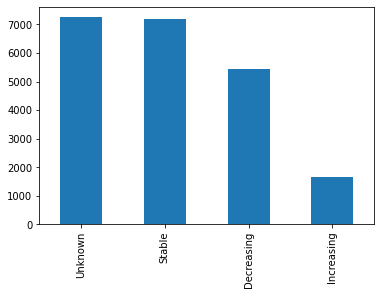

In [11]:
df.trend.value_counts().plot(kind='bar')

## Data cleaning

For the threat_level some datapoints are missing. We checked the species directly on the webpage.
There is no value for is and so and we use 'Data Deficient' for these.

In [12]:
df.threat_level.unique()

array(['Least Concern', 'Vulnerable', 'Critically Endangered',
       'Data Deficient', 'Near Threatened', 'Endangered', 'Extinct',
       'Extinct in the Wild',
       '[missing "en.shared.categories.cd" translation]'], dtype=object)

In [13]:
# missing data on web search
# give "[missing "en.shared.categories.cd" translation]" 'Data Deficient" label
df.threat_level.replace({'[missing "en.shared.categories.cd" translation]': 'Data Deficient'}, inplace=True)

# Inspect species

In [14]:
# number of animal species in OECD countrys
df.scientific_name.unique().shape[0]

10285

In [15]:
species = df.drop(columns=['country']).drop_duplicates()
species.shape

KeyError: "['country'] not found in axis"

In [37]:
species.head()

,class,common_name,scientific_name,trend,region,threat_level
0,Mammals,Brown Bear,Ursus arctos,Stable,Global,Least Concern
1,Mammals,Greater Mouse-eared Bat,Myotis myotis,Stable,Global,Least Concern
3,Mammals,Wild Boar,Sus scrofa,Unknown,Global,Least Concern
4,Mammals,Gray Whale,Eschrichtius robustus,Stable,Global,Least Concern
5,Insects,Large Copper,Lycaena dispar,Unknown,Global,Near Threatened


<AxesSubplot:xlabel='class'>

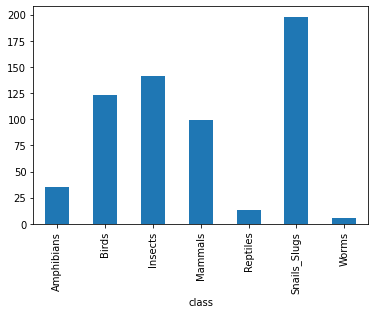

In [38]:
# species per class in OECD countrys
species_per_class = species.groupby('class')['scientific_name'].count()
species_per_class.plot(kind="bar")

# Create data for species per trend per country

In [39]:
# transform data
grouped = df.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot(index='country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country.shape

(29, 4)

In [40]:
species_trend_country.head()

trend,Decreasing,Increasing,Stable,Unknown
country,,,,
Australia,4.0,0.0,1.0,44.0
Austria,10.0,3.0,3.0,4.0
Belgium,7.0,1.0,1.0,2.0
Canada,5.0,0.0,2.0,11.0
Czech Republic,6.0,1.0,3.0,5.0


In [46]:
species_trend_country.sum()

trend
Decreasing    235.0
Increasing     50.0
Stable         85.0
Unknown       448.0
dtype: float64

## Create data for species per threat level per country

In [41]:
# check for missing values
df.isna().sum()

class                0
common_name        249
scientific_name      0
trend                0
region               0
threat_level         0
country              0
dtype: int64

In [42]:
# transform data
grouped = df.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl_country = grouped.pivot(index='country', columns='threat_level', values='count')
species_tl_country = species_tl_country.fillna(0.0)

In [43]:
species_tl_country.head()

threat_level,Critically Endangered,Data Deficient,Endangered,Extinct,Extinct in the Wild,Least Concern,Near Threatened,Vulnerable
country,,,,,,,,
Australia,5.0,0.0,0.0,40.0,0.0,3.0,1.0,0.0
Austria,5.0,0.0,0.0,1.0,0.0,8.0,2.0,4.0
Belgium,0.0,0.0,1.0,0.0,0.0,6.0,1.0,3.0
Canada,4.0,1.0,1.0,6.0,0.0,4.0,1.0,1.0
Czech Republic,1.0,3.0,0.0,0.0,0.0,8.0,2.0,1.0


This DataFrames include the same data as the "Table 6a" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Create data for species per class per country

In [44]:
# transform data
grouped = df.groupby(['country', 'class'])['scientific_name'].count().reset_index(name='count')
species_class_country = grouped.pivot(index='country', columns='class', values='count')
species_class_country = species_class_country.fillna(0.0)

In [45]:
species_class_country.head()

class,Amphibians,Birds,Insects,Mammals,Reptiles,Snails_Slugs,Worms
country,,,,,,,
Australia,5.0,11.0,1.0,27.0,0.0,4.0,1.0
Austria,0.0,5.0,4.0,5.0,1.0,5.0,0.0
Belgium,1.0,0.0,6.0,4.0,0.0,0.0,0.0
Canada,0.0,4.0,3.0,3.0,3.0,5.0,0.0
Czech Republic,0.0,2.0,10.0,3.0,0.0,0.0,0.0


This DataFrames include the same data as the "Table 5" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.